In [1]:
import json
import os
import random
from os.path import join, splitext

import cv2 as cv
import numpy as np
import pandas as pd
from itertools import chain
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

from utils import map_data_frame_from_json, map_data_frame_to_json

In [2]:
df = pd.read_csv('../3_bdd100k/1_original_statistics.csv', index_col=0)
df = map_data_frame_from_json(df, column_list=['bbox'])
df.head()

,filename,width,height,size,name,bbox,area,area_p,weather,timeofday,scene,occluded,truncated,trafic_light_color
0,0000f77c-6257be58.jpg,1280,720,921600,traffic light,"[1125, 133, 1156, 210]",2414,0.0,clear,daytime,city street,False,False,G
1,0000f77c-6257be58.jpg,1280,720,921600,traffic light,"[1156, 136, 1191, 210]",2563,0.0,clear,daytime,city street,False,False,G
21,0001542f-5ce3cf52.jpg,1280,720,921600,traffic light,"[535, 324, 553, 335]",195,0.0,clear,night,city street,False,False,G
22,0001542f-5ce3cf52.jpg,1280,720,921600,traffic light,"[488, 324, 501, 336]",157,0.0,clear,night,city street,False,False,G
37,0001542f-7c670be8.jpg,1280,720,921600,traffic light,"[616, 324, 628, 336]",132,0.0,clear,night,highway,False,False,R


In [432]:
# df = df[df.name == 'traffic light']
# len(df)

In [433]:
df_groupped = df.groupby(by='filename')

In [434]:
def get_intersection(bbox1, bbox2):
    x0, y0, x1, y1 = bbox1
    x2, y2, x3, y3 = bbox2
    x5, y5 = max(x0, x2), max(y0, y2)
    x6, y6 = min(x1, x3), min(y1, y3)

    if x5 >= x6 or y5 >= y6:
        return None

    return x5, y5, x6, y6

def get_sample_boxes(image_df, box_area=(0.2, 0.4), padding=0.1, max_attempts_count=100):
    result_list = []
    for idx, row in image_df.iterrows():
        image_width, image_height = row.width, row.height
        item_bbox = row.bbox
        x0, y0, x1, y1 = item_bbox
        width = x1 - x0
        height = y1 - y0
        area = width * height
        target_area = area / random.uniform(box_area[0], box_area[1])
        target_side = np.sqrt(target_area)
        sample_padding = int(target_side * padding)
        target_side = max(target_side, max(width, height) + sample_padding)
        target_side = int(target_side)

        sample_x0 = x1 - target_side
        sample_y0 = y1 - target_side
        sample_x1 = x0
        sample_y1 = y0
        sample_x0 = max(sample_x0, 0)
        sample_y0 = max(sample_y0, 0)
        sample_x1 = min(sample_x1, image_width - target_side)
        sample_y1 = min(sample_y1, image_height - target_side)
        sample_x0, sample_y0 = sample_x0 + sample_padding, sample_y0 + sample_padding
        sample_x1, sample_y1 = sample_x1 - sample_padding, sample_y1 - sample_padding
        if sample_x0 >= sample_x1 or sample_y0 >= sample_y1:
            continue

        bbox_max = (sample_x0, sample_y0, sample_x1 + target_side, sample_y1 + target_side)
        bbox_invariant = x0 - padding, y0 - padding, x1 + padding, y1 + padding
        skip = False
        bbox_to_avoid_list = []
        for idx_inner, row_inner in image_df.iterrows():
            if idx_inner == idx:
                continue
            check_bbox = row_inner.bbox

            intersection_max = get_intersection(bbox_max, check_bbox)
            if intersection_max is None:
                continue
            bbox_to_avoid_list.append(intersection_max)

            intersection_invariant = get_intersection(bbox_invariant, check_bbox)
            if intersection_invariant is not None:
                skip = True
                break

        if skip:
            continue

        result_bbox = None
        for _ in range(max_attempts_count):
            candidate_x0, candidate_y0 = random.uniform(sample_x0, sample_x1), \
                random.uniform(sample_y0, sample_y1)
            candidate_x1, candidate_y1 = candidate_x0 + target_side, candidate_y0 + target_side
            candidate_bbox = int(candidate_x0), int(candidate_y0), int(candidate_x1), int(candidate_y1)
            if any([get_intersection(candidate_bbox, avoid_bbox) is not None
                    for avoid_bbox in bbox_to_avoid_list]):
                continue

            result_bbox = candidate_bbox

        if result_bbox is None:
            continue

        result_list.append((idx, result_bbox))

    return result_list

In [435]:
random.seed(42)
data_list = []
for filename, df_group in tqdm(list(df_groupped)[:]):
    sample_box_list = get_sample_boxes(df_group)
    sample_df = pd.DataFrame(sample_box_list, columns=['id', 'sample_bbox']).set_index('id')
    sample_df = pd.merge(df_group, sample_df,
                         how='inner', left_index=True, right_index=True)
    data_list.append(sample_df)

  0%|          | 0/45052 [00:00<?, ?it/s]

In [436]:
df_samples = pd.concat(data_list, axis=0, ignore_index=True)
df_samples.rename({'bbox': 'object_bbox'}, axis='columns', inplace=True)
print(len(df_samples))
df_samples.head()

121408


,filename,width,height,size,name,object_bbox,area,area_p,weather,timeofday,scene,occluded,truncated,trafic_light_color,sample_bbox
0,0001542f-5ce3cf52.jpg,1280,720,921600,traffic light,"[535, 324, 553, 335]",195,0.0,clear,night,city street,False,False,G,"(532, 320, 559, 347)"
1,0001542f-5ce3cf52.jpg,1280,720,921600,traffic light,"[488, 324, 501, 336]",157,0.0,clear,night,city street,False,False,G,"(481, 321, 506, 346)"
2,0001542f-7c670be8.jpg,1280,720,921600,traffic light,"[616, 324, 628, 336]",132,0.0,clear,night,highway,False,False,R,"(613, 320, 633, 340)"
3,0001542f-7c670be8.jpg,1280,720,921600,traffic light,"[531, 331, 541, 342]",115,0.0,clear,night,highway,False,False,G,"(526, 325, 544, 343)"
4,00067cfb-5443fe39.jpg,1280,720,921600,traffic light,"[581, 353, 587, 364]",65,0.0,clear,daytime,city street,False,False,G,"(576, 351, 590, 365)"


In [437]:
# {name for name, _ in list(df_groupped)[:10]}.difference(df_samples.filename.unique())

In [438]:
df_out = df_samples.copy()
df_out = map_data_frame_to_json(df_out, column_list=['sample_bbox', 'object_bbox'])
df_out.to_csv('../3_bdd100k/2_samples.csv', index=False)

# Split to train/val/test

In [6]:
df_samples = pd.read_csv('../3_bdd100k/2_samples.csv')
df_samples = map_data_frame_from_json(df_samples, column_list=['sample_bbox', 'object_bbox'])
print(len(df_samples))
df_samples.head()

121408


,filename,width,height,size,name,object_bbox,area,area_p,weather,timeofday,scene,occluded,truncated,trafic_light_color,sample_bbox
0,0001542f-5ce3cf52.jpg,1280,720,921600,traffic light,"[535, 324, 553, 335]",195,0.0,clear,night,city street,False,False,G,"[532, 320, 559, 347]"
1,0001542f-5ce3cf52.jpg,1280,720,921600,traffic light,"[488, 324, 501, 336]",157,0.0,clear,night,city street,False,False,G,"[481, 321, 506, 346]"
2,0001542f-7c670be8.jpg,1280,720,921600,traffic light,"[616, 324, 628, 336]",132,0.0,clear,night,highway,False,False,R,"[613, 320, 633, 340]"
3,0001542f-7c670be8.jpg,1280,720,921600,traffic light,"[531, 331, 541, 342]",115,0.0,clear,night,highway,False,False,G,"[526, 325, 544, 343]"
4,00067cfb-5443fe39.jpg,1280,720,921600,traffic light,"[581, 353, 587, 364]",65,0.0,clear,daytime,city street,False,False,G,"[576, 351, 590, 365]"


In [3]:
# for bdd100k
df_samples = df_samples[(df_samples.timeofday != 'night')
                        & (df_samples.occluded == False)
                        & (df_samples.truncated == False)
                        & ((df_samples.trafic_light_color == 'G') | (pd.isna(df_samples.trafic_light_color)))]
len(df_samples)

40284

In [210]:
# for cards
df_samples = df_samples[df_samples.name.map(lambda it: 'S' in it)]
len(df_samples)

11008

## Sample data

756 5775


<Axes: ylabel='Density'>

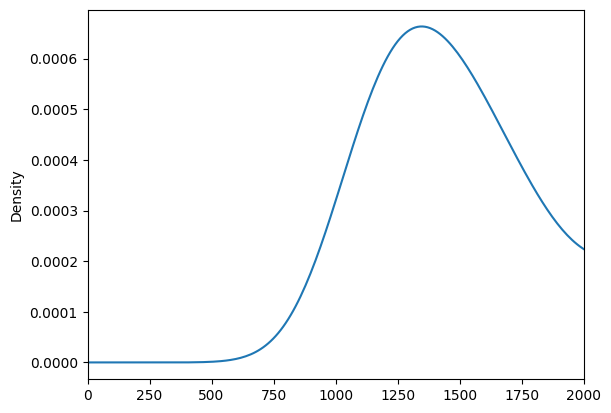

In [211]:
print(df_samples.area.min(), df_samples.area.max())
df_samples.area.plot(kind='density', xlim=(0, 2000))

In [212]:
class_count = df_samples['name'].nunique()
min_class_size = df_samples.name.value_counts().min()
class_indexes = list(chain(*[[i] * min_class_size for i in range(class_count)]))
target_indexes_list = train_test_split(class_indexes,
                                       train_size=2000,
                                       random_state=42,
                                       stratify=class_indexes,
                                       shuffle=True)[0]

class_count_list = [0] * class_count
for idx in target_indexes_list:
    class_count_list[idx] += 1
class_name_list = df_samples['name'].unique()
class_name_count_series = pd.Series(class_count_list, index=class_name_list)

# target_object_area = 600  # helmets
target_object_area = 1400  # playing cards
# target_object_area = 1200  # traffic lights
def sample_class_group(df_class):
    sample_size = class_name_count_series.loc[df_class.name]
    df_class['diff'] = df_class['area'].map(lambda area: abs(area - target_object_area))
    df_class.sort_values(by='diff', ascending=True, inplace=True, ignore_index=True)
    df_class.drop(columns=['diff'], inplace=True)

    return df_class.iloc[:sample_size]

df_filtered = df_samples.groupby(by='name').apply(sample_class_group)
df_filtered.index = df_filtered.index.droplevel(0)
print(len(df_filtered))
df_filtered.head()

2000


,filename,width,height,size,name,object_bbox,area,area_p,sample_bbox
0,877607342_jpg.rf.354e9fd2fae90f5271ea6821c4e80...,640,640,409600,10S,"[242, 350, 281, 386]",1404,0.003428,"[222, 342, 288, 408]"
1,499735035_jpg.rf.7d018e3b933e07faa128e19ed06cd...,640,640,409600,10S,"[436, 367, 481, 398]",1395,0.003406,"[429, 344, 489, 404]"
2,043866152_jpg.rf.24750a7b60ed9d2e71b69aea41c3f...,640,640,409600,10S,"[124, 405, 169, 436]",1395,0.003406,"[103, 384, 177, 458]"
3,506007550_jpg.rf.f6db12a5ad387bef3cb4d711e2b68...,640,640,409600,10S,"[231, 257, 262, 302]",1395,0.003406,"[205, 245, 270, 310]"
4,399475375_jpg.rf.3efabd24b3dd3f61218a8c8d4168c...,640,640,409600,10S,"[370, 434, 415, 465]",1395,0.003406,"[355, 426, 431, 502]"


In [213]:
class_counts = df_filtered.name.value_counts()
print(f'class_counts min: {class_counts.min()}\n'
      f'class_counts max: {class_counts.max()}\n'
      f'area min: {df_filtered["area"].min()}\n'
      f'area max: {df_filtered["area"].max()}\n'
      f'area diff: {df_filtered["area"].max() - df_filtered["area"].min()}')

class_counts min: 153
class_counts max: 154
area min: 1200
area max: 1600
area diff: 400


# Generate descriptors

In [214]:
df_train, df_val = train_test_split(df_filtered,
                                    train_size=1000,
                                    random_state=42,
                                    shuffle=True)
df_val, df_test = train_test_split(df_val,
                                   train_size=500,
                                   random_state=42,
                                   shuffle=True)
len(df_train), len(df_val), len(df_test)

(1000, 500, 500)

In [215]:
def save_df(df_to_save, path):
    df_out = df_to_save.copy()
    df_out = map_data_frame_to_json(df_out, column_list=['sample_bbox', 'object_bbox'])
    df_out.to_csv(path, index=True)

In [184]:
save_df(df_train, '../3_bdd100k/3_train.csv')
save_df(df_val, '../3_bdd100k/3_val.csv')
save_df(df_test, '../3_bdd100k/3_test.csv')

# Generate to YOLOv8 format data

In [2]:
def generate_yolov8(descriptor_path,
                    image_folder_path,
                    output_folder_path,
                    sample=1.0,
                    random_state=42,
                    draw_bbox=False,
                    precision=6):
    df_descriptor = pd.read_csv(descriptor_path,  index_col=0)
    df_descriptor = map_data_frame_from_json(df_descriptor, column_list=['object_bbox', 'sample_bbox'])
    df_descriptor = df_descriptor.sample(frac=sample, random_state=random_state, ignore_index=False)
    print(f'Generating descriptors for {len(df_descriptor)} samples...')
    output_image_folder_path = join(output_folder_path, 'images')
    output_label_folder_path = join(output_folder_path, 'labels')
    os.makedirs(output_image_folder_path, exist_ok=True)
    os.makedirs(output_label_folder_path, exist_ok=True)
    for idx, row in tqdm(df_descriptor.iterrows()):
        img_path = join(image_folder_path, row.filename)
        x0, y0, x1, y1 = row.sample_bbox
        img = cv.imread(img_path)
        roi = img[y0: y1, x0: x1]
        object_x0, object_y0, object_x1, object_y1 = row.object_bbox
        object_x0, object_x1 = object_x0 - x0, object_x1 - x0
        object_y0, object_y1 = object_y0 - y0, object_y1 - y0
        filename_base, ext = splitext(row.filename)
        with open(join(output_label_folder_path, f'{filename_base}_{str(idx)}.txt'), mode='w+') as f:
            x_center = (object_x0 + object_x1) / 2 / roi.shape[1]
            y_center = (object_y0 + object_y1) / 2 / roi.shape[0]
            width = (object_x1 - object_x0) / roi.shape[1]
            height = (object_y1 - object_y0) / roi.shape[0]
            x_center = round(x_center, precision)
            y_center = round(y_center, precision)
            width = round(width, precision)
            height = round(height, precision)
            f.writelines([f'0 {x_center} {y_center} {width} {height}'])

        if draw_bbox:
            cv.rectangle(roi, (object_x0, object_y0), (object_x1, object_y1), (0, 0, 255), 1)
        cv.imwrite(join(output_image_folder_path, f'{filename_base}_{str(idx)}{ext}'), roi)


In [8]:
generate_yolov8('../3_bdd100k/3_test.csv',
                '../3_bdd100k/images',
                '../3_bdd100k/dataset_yolo_temp/test',
                draw_bbox=True,
                sample=1.0)

Generating descriptors for 500 samples...


0it [00:00, ?it/s]

In [5]:
df = pd.read_csv('../1_helmet/2_samples.csv')
df.head()

,filename,width,height,size,name,object_bbox,area,area_p,sample_bbox
0,000001_jpg.rf.fddb09e33a544e332617f8ceb53ee805...,500,375,187500,helmet,"[178, 83, 230, 143]",3120,0.016640,"[164, 73, 261, 170]"
1,000001_jpg.rf.fddb09e33a544e332617f8ceb53ee805...,500,375,187500,helmet,"[111, 144, 134, 174]",690,0.003680,"[100, 136, 142, 178]"
2,000002_jpg.rf.85b55e30b8ce745e3c16966991a38018...,500,333,166500,helmet,"[272, 53, 325, 111]",3074,0.018462,"[253, 30, 355, 132]"
3,000002_jpg.rf.85b55e30b8ce745e3c16966991a38018...,500,333,166500,helmet,"[141, 82, 181, 131]",1960,0.011772,"[125, 74, 199, 148]"
4,000003_jpg.rf.9fc4dfe06775f585757ede9300ba6af9...,400,264,105600,helmet,"[175, 152, 204, 189]",1073,0.010161,"[151, 134, 219, 202]"


# Convert to COCO format

In [195]:
def generate_coco(descriptor_path,
                  image_folder_path,
                  output_folder_path,
                  annotation_name,
                  category_name,
                  draw_bbox=False,
                  sample=1.0,
                  random_state=42):
    df_descriptor = pd.read_csv(descriptor_path, index_col=0)
    df_descriptor = map_data_frame_from_json(df_descriptor, column_list=['object_bbox', 'sample_bbox'])
    df_descriptor = df_descriptor.sample(frac=sample, random_state=random_state, ignore_index=False)
    print(f'Generating descriptors for {len(df_descriptor)} samples...')
    output_image_folder_path = join(output_folder_path, 'images')
    annotation_file_path = join(output_folder_path, 'annotations', annotation_name)
    os.makedirs(output_image_folder_path, exist_ok=True)
    os.makedirs(os.path.dirname(annotation_file_path), exist_ok=True)
    image_descriptor_list = []
    annotation_list = []
    for sample_id, row in tqdm(df_descriptor.iterrows()):
        img_path = join(image_folder_path, row.filename)
        x0, y0, x1, y1 = row.sample_bbox
        img = cv.imread(img_path)
        roi = img[y0: y1, x0: x1]
        object_x0, object_y0, object_x1, object_y1 = row.object_bbox
        object_x0, object_x1 = object_x0 - x0, object_x1 - x0
        object_y0, object_y1 = object_y0 - y0, object_y1 - y0
        object_width = object_x1 - object_x0
        object_height = object_y1 - object_y0
        filename_base, ext = splitext(row.filename)

        image_sample_filename = f'{filename_base}_{str(sample_id)}{ext}'
        image_descriptor_list.append({
            "file_name": image_sample_filename,
            "height": roi.shape[0],
            "width": roi.shape[1],
            "id": sample_id,
        })
        annotation_list.append({
            "segmentation": [],
            "iscrowd": 0,
            "image_id": sample_id,
            "category_id": 1,
            "bbox": [object_x0, object_y0, object_width, object_height],
            "area": object_width * object_height,
            "id": sample_id,
        })

        if draw_bbox:
            cv.rectangle(roi, (object_x0, object_y0), (object_x1, object_y1), (0, 0, 255), 1)
        cv.imwrite(join(output_image_folder_path, image_sample_filename), roi)
    categories = [{
        "supercategory": category_name,
        "id": 1,
        "name": category_name
    }]
    with open(annotation_file_path, mode='w+') as f:
        json.dump({
            "categories": categories,
            "images": image_descriptor_list,
            "annotations": annotation_list
        }, f, indent=4)

In [205]:
generate_coco('../3_bdd100k/3_val.csv',
              '../3_bdd100k/images',
              '../3_bdd100k/dataset_coco/',
              'annotation_val_small.json',
              'card',
              draw_bbox=False,
              sample=0.5)

Generating descriptors for 250 samples...


0it [00:00, ?it/s]